# Denver 2016 Bike Share Regression Modeling

## 1. Introduction

The data exploration performed on the Denver Trips dataset indicates weather variables have a significant impact on the number
of checkouts. This section will focus on investigating the use of various regression models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the analyses
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('data/style-table.css').read() + open('data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/2016_Boulder_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(98270, 13)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Checkout_WeekDay,Checkout_Month
0,Boulder B-cycle,R1073079,Semester (150-day),516,2016-01-01,0,15th & Pearl,2016-01-01,01:10:00,UCAR Mitchell Lane,22,4,1


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Trip_Duration'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98270 entries, 0 to 98269
Data columns (total 4 columns):
Checkout_Date       98270 non-null object
Checkout_Hour       98270 non-null int64
Checkout_WeekDay    98270 non-null int64
Checkout_Month      98270 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.0+ MB


### Re-arrange columns to set up target class

In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98270 entries, 0 to 98269
Data columns (total 4 columns):
Checkout_Date       98270 non-null object
Checkout_Month      98270 non-null int64
Checkout_WeekDay    98270 non-null int64
Checkout_Hour       98270 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.0+ MB


In [10]:
dW = pd.read_csv("data/Boulder_2016_Hourly_Weather_Forecast.csv")

In [11]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [12]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [13]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [14]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [15]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98270 entries, 0 to 98269
Data columns (total 4 columns):
Checkout_Date       98270 non-null object
Checkout_Month      98270 non-null int64
Checkout_WeekDay    98270 non-null int64
Checkout_Hour       98270 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.0+ MB


In [16]:
dFW['Number_Of_Checkouts'].sum()

98270

In [17]:
dFW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7075 entries, 0 to 7074
Data columns (total 5 columns):
Checkout_Date          7075 non-null object
Checkout_Month         7075 non-null int64
Checkout_WeekDay       7075 non-null int64
Checkout_Hour          7075 non-null int64
Number_Of_Checkouts    7075 non-null int64
dtypes: int64(4), object(1)
memory usage: 276.4+ KB


In [18]:
dFW.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Number_Of_Checkouts
0,2016-01-01,1,4,0,1
1,2016-01-01,1,4,4,1
2,2016-01-01,1,4,9,1
3,2016-01-01,1,4,10,3
4,2016-01-01,1,4,11,4


In [19]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
Date                   8760 non-null object
Checkout_Hour          8760 non-null int64
apparentTemperature    8760 non-null float64
cloudCover             8758 non-null float64
humidity               8760 non-null float64
temperature            8760 non-null float64
visibility             8760 non-null float64
windSpeed              8760 non-null float64
Checkout_WeekDay       8760 non-null int32
Checkout_Month         8760 non-null int32
dtypes: float64(6), int32(2), int64(1), object(1)
memory usage: 616.0+ KB


In [20]:
dW.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay,Checkout_Month
0,2016-01-01,0,0.65,0.01,0.83,7.52,7.75,3.50,4,1
1,2016-01-01,1,7.90,0.01,0.80,7.90,9.41,0.42,4,1
2,2016-01-01,2,6.47,0.00,0.76,6.47,9.59,0.57,4,1
3,2016-01-01,3,-2.39,0.00,0.78,5.69,9.65,4.04,4,1
4,2016-01-01,4,-2.51,0.00,0.81,5.37,9.61,3.90,4,1


In [21]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [22]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 14 columns):
Date                   8760 non-null object
Checkout_Hour          8760 non-null int64
apparentTemperature    8760 non-null float64
cloudCover             8758 non-null float64
humidity               8760 non-null float64
temperature            8760 non-null float64
visibility             8760 non-null float64
windSpeed              8760 non-null float64
Checkout_WeekDay_x     8760 non-null int32
Checkout_Month_x       8760 non-null int32
Checkout_Date          7056 non-null object
Checkout_Month_y       7056 non-null float64
Checkout_WeekDay_y     7056 non-null float64
Number_Of_Checkouts    7056 non-null float64
dtypes: float64(9), int32(2), int64(1), object(2)
memory usage: 958.1+ KB


In [23]:
dT.tail()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
8755,2016-12-31,19,31.62,0.03,0.53,31.62,10.0,2.67,5,12,NaN,NaN,NaN,NaN
8756,2016-12-31,20,30.99,0.05,0.55,30.99,10.0,2.10,5,12,2016-12-31,12.0,5.0,7.0
8757,2016-12-31,21,28.96,0.04,0.60,28.96,10.0,1.17,5,12,2016-12-31,12.0,5.0,1.0
8758,2016-12-31,22,28.37,0.00,0.61,28.37,10.0,2.53,5,12,2016-12-31,12.0,5.0,3.0
8759,2016-12-31,23,28.60,0.05,0.61,28.60,10.0,1.35,5,12,NaN,NaN,NaN,NaN


In [24]:
dT['Number_Of_Checkouts'].sum()

97911.0

In [25]:
dT.isnull().values.any()

True

In [26]:
nan_rows = dT[dT.isnull().T.any().T]

In [27]:
dT = dT.drop(dT.index[nan_rows.index])

In [28]:
dT.isnull().values.any()

False

In [29]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7056 entries, 0 to 8758
Data columns (total 14 columns):
Date                   7056 non-null object
Checkout_Hour          7056 non-null int64
apparentTemperature    7056 non-null float64
cloudCover             7056 non-null float64
humidity               7056 non-null float64
temperature            7056 non-null float64
visibility             7056 non-null float64
windSpeed              7056 non-null float64
Checkout_WeekDay_x     7056 non-null int32
Checkout_Month_x       7056 non-null int32
Checkout_Date          7056 non-null object
Checkout_Month_y       7056 non-null float64
Checkout_WeekDay_y     7056 non-null float64
Number_Of_Checkouts    7056 non-null float64
dtypes: float64(9), int32(2), int64(1), object(2)
memory usage: 771.8+ KB


In [30]:
dT.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
0,2016-01-01,0,0.65,0.01,0.83,7.52,7.75,3.50,4,1,2016-01-01,1.0,4.0,1.0
4,2016-01-01,4,-2.51,0.00,0.81,5.37,9.61,3.90,4,1,2016-01-01,1.0,4.0,1.0
9,2016-01-01,9,6.74,0.02,0.65,14.37,10.00,4.70,4,1,2016-01-01,1.0,4.0,1.0
10,2016-01-01,10,9.90,0.07,0.56,19.58,10.00,7.76,4,1,2016-01-01,1.0,4.0,3.0
11,2016-01-01,11,21.94,0.07,0.40,26.07,10.00,3.45,4,1,2016-01-01,1.0,4.0,4.0


In [31]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [32]:
# Convert Checkout_Hour to integer type
dT['Number_Of_Checkouts'] = dT['Number_Of_Checkouts'].astype(int)

In [33]:
dT.head(1)

,Checkout_Hour,Apparent_Temperature,Cloud_Cover,Humidity,Temperature,Visibility,Wind_Speed,Checkout_WeekDay,Checkout_Month,Checkout_Date,Number_Of_Checkouts
0,0,0.65,0.01,0.83,7.52,7.75,3.5,4,1,2016-01-01,1


In [34]:
data = dT.copy(deep=True)

In [35]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [36]:
data = data[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

In [37]:
data.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts
0,2016-01-01,1,4,0,7.52,0.65,0.01,0.83,3.50,7.75,1
4,2016-01-01,1,4,4,5.37,-2.51,0.00,0.81,3.90,9.61,1
9,2016-01-01,1,4,9,14.37,6.74,0.02,0.65,4.70,10.00,1
10,2016-01-01,1,4,10,19.58,9.90,0.07,0.56,7.76,10.00,3
11,2016-01-01,1,4,11,26.07,21.94,0.07,0.40,3.45,10.00,4


### Convert the numeric Calendar and Clock columns into categorical columns

In [38]:
month_dummies = pd.get_dummies(data.Checkout_Month, prefix='month')

In [39]:
weekday_dummies = pd.get_dummies(data.Checkout_WeekDay, prefix='weekday')

In [40]:
hour_dummies = pd.get_dummies(data.Checkout_Hour, prefix='hour')

In [41]:
data = pd.concat([data, month_dummies, weekday_dummies, hour_dummies], axis=1)

In [42]:
data.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2016-01-01,1,4,0,7.52,0.65,0.01,0.83,3.50,7.75,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016-01-01,1,4,4,5.37,-2.51,0.00,0.81,3.90,9.61,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2016-01-01,1,4,9,14.37,6.74,0.02,0.65,4.70,10.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2016-01-01,1,4,10,19.58,9.90,0.07,0.56,7.76,10.00,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
11,2016-01-01,1,4,11,26.07,21.94,0.07,0.40,3.45,10.00,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### Keep 10 samples aside for use in prediction on unseen samples

In [43]:
dUT = data.sample(n=10, random_state=123)

In [44]:
del_rows = dUT.index

In [45]:
data.drop(del_rows, axis=0, inplace=True)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7046 entries, 0 to 8758
Data columns (total 54 columns):
Checkout_Date           7046 non-null object
Checkout_Month          7046 non-null int32
Checkout_WeekDay        7046 non-null int32
Checkout_Hour           7046 non-null int64
Temperature             7046 non-null float64
Apparent_Temperature    7046 non-null float64
Cloud_Cover             7046 non-null float64
Humidity                7046 non-null float64
Wind_Speed              7046 non-null float64
Visibility              7046 non-null float64
Number_Of_Checkouts     7046 non-null int32
month_1                 7046 non-null uint8
month_2                 7046 non-null uint8
month_3                 7046 non-null uint8
month_4                 7046 non-null uint8
month_5                 7046 non-null uint8
month_6                 7046 non-null uint8
month_7                 7046 non-null uint8
month_8                 7046 non-null uint8
month_9                 7046 non-null uint8


In [47]:
data = data[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Number_Of_Checkouts']]

In [48]:
data.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Wind_Speed,Humidity,Visibility,Number_Of_Checkouts
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,0,7.52,0.65,0.01,3.50,0.83,7.75,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,4,5.37,-2.51,0.00,3.90,0.81,9.61,1
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,9,14.37,6.74,0.02,4.70,0.65,10.00,1
10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,10,19.58,9.90,0.07,7.76,0.56,10.00,3
11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,11,26.07,21.94,0.07,3.45,0.40,10.00,4


In [49]:
array = data.values

In [50]:
X = array[:,0:47]
X[0]

array([ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  1.  ,  4.  ,  0.  ,  7.52,  0.65,  0.01,  3.5 ,
        0.83,  7.75])

In [51]:
y = array[:,47]
y[0]

1.0

## Feature Correlations

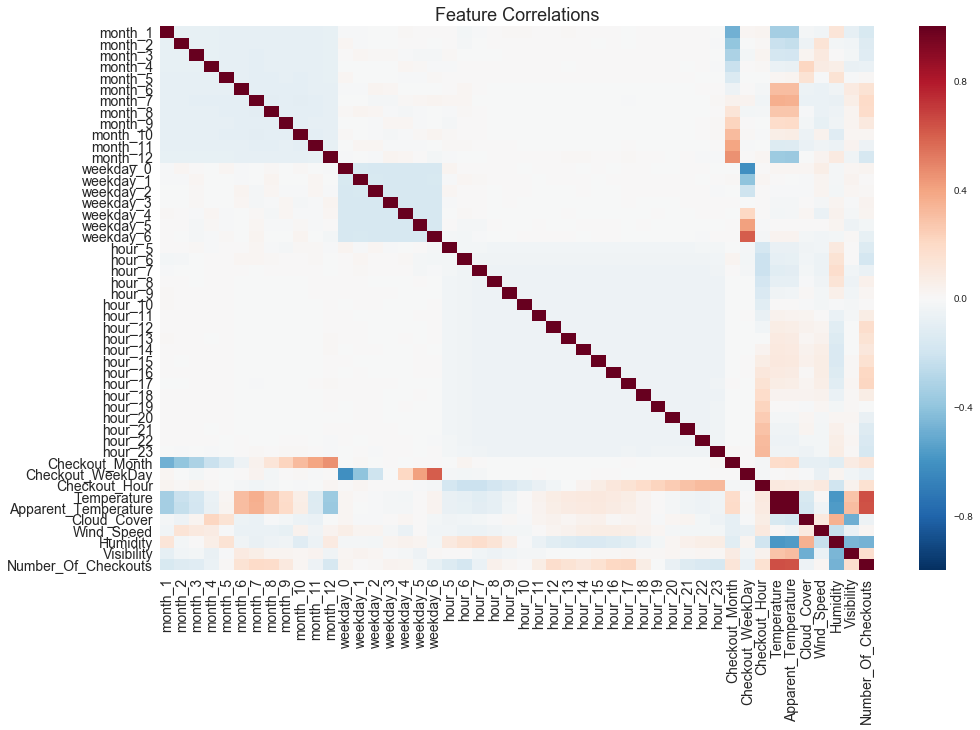

In [52]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [53]:
features = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 2. Modeling - All Features

### Plot Feature Importance

In [54]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,14))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

### Get Regression Metrics

In [55]:
def get_regression_metrics(model, actual, predicted):
    regression_metrics = {'R Squared' : metrics.r2_score(actual, predicted)**0.5,
                          'RMSE' : metrics.mean_squared_error(actual, predicted)}
    dML_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

### Linear Regression

In [56]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.intercept_: {}".format(lr.intercept_))
print("lr.coef_: {}".format(lr.coef_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.intercept_: -811089233288.8225
lr.coef_: [ -2.83187436e+07  -2.83187441e+07  -2.83187449e+07  -2.83187443e+07
  -2.83187426e+07  -2.83187431e+07  -2.83187415e+07  -2.83187410e+07
  -2.83187425e+07  -2.83187425e+07  -2.83187427e+07  -2.83187438e+07
   8.11117552e+11   8.11117552e+11   8.11117552e+11   8.11117552e+11
   8.11117552e+11   8.11117552e+11   8.11117552e+11   5.23597307e-01
   1.42082864e+00   9.20228910e+00   1.54403913e+01   1.27516098e+01
   1.08758800e+01   1.36300040e+01   1.78613190e+01   1.59805730e+01
   1.42807813e+01   1.61303735e+01   1.91827115e+01   2.06719003e+01
   1.35449247e+01   9.80937636e+00   6.61130200e+00   4.81691064e+00
   3.43829651e+00   1.17753433e+00   6.18269309e-01  -2.65673498e-01
  -1.72616768e+00  -2.61797711e-01   3.18066031e-02   2.23342232e-01]

Training Set Score: 0.680
Testing Set Score: 0.676


,Linear Regression
R Squared,0.822253
RMSE,46.268837


### Lasso Regression

In [57]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.01)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("lso.intercept_: {}".format(lso.intercept_))
print("lso.coef_: {}".format(lso.coef_))
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

lso.intercept_: -16.006301401362478
lso.coef_: [  0.          -0.53320746  -1.46295096  -1.28817091   0.02653473
  -0.77747466   0.45733368   1.1307445   -0.           0.05662671
   0.3291746   -0.           0.36520341  -0.19659408  -0.           1.01329842
   0.86379623  -1.12341582  -3.57776047  -0.21798782   0.           7.62253775
  13.69650605  10.88808821   8.91911048  11.53760723  15.6822635
  13.75126115  12.01217916  13.85831741  16.97609094  18.52415906
  11.44401093   7.85942567   4.69980285   2.92476668   1.68053912
  -0.05497317   0.65297076  -0.26608044  -0.32748055  -0.2699661   -0.
   0.23426185]
Training Set Score: 0.677
Testing Set Score: 0.674


,Lasso Regression
R Squared,0.821127
RMSE,46.533272


### Ridge Regression

In [58]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.01)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("rge.intercept_: {}".format(rge.intercept_))
print("rge.coef_: {}".format(rge.coef_))
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

rge.intercept_: -16.006301401362478
rge.coef_: [  0.          -0.53320746  -1.46295096  -1.28817091   0.02653473
  -0.77747466   0.45733368   1.1307445   -0.           0.05662671
   0.3291746   -0.           0.36520341  -0.19659408  -0.           1.01329842
   0.86379623  -1.12341582  -3.57776047  -0.21798782   0.           7.62253775
  13.69650605  10.88808821   8.91911048  11.53760723  15.6822635
  13.75126115  12.01217916  13.85831741  16.97609094  18.52415906
  11.44401093   7.85942567   4.69980285   2.92476668   1.68053912
  -0.05497317   0.65297076  -0.26608044  -0.32748055  -0.2699661   -0.
   0.23426185]
Training Set Score: 0.677
Testing Set Score: 0.674


,Ridge Regression
R Squared,0.821127
RMSE,46.533272


### Bayesian Ridge Regression

In [59]:
# Bayesian Ridge Regressor
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("brr.intercept_: {:.3f}".format(brr.intercept_))
print("brr.coef_: {}".format(brr.coef_))
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

brr.intercept_: -16.141
brr.coef_: [ -0.46538662  -0.96757232  -1.74545291  -1.25723422   0.46042863
  -0.1438539    1.41068313   1.97314206   0.44061749   0.49443783
   0.41396794  -0.61377712   0.83049055   0.06965004   0.34009046
   1.45563485   1.30193131  -0.77239929  -3.22539793   0.24457609
   1.13880767   8.88907826  15.08441119  12.38013131  10.49127001
  13.21583329  17.41875523  15.53324618  13.8315973   15.67521797
  18.73187141  20.22853273  13.1309246    9.42795665   6.25069112
   4.46751118   3.11002086   0.86689033   0.6254017   -0.26802495
  -1.53737642  -0.26310769  -0.06425806   0.21955581]
Training Set Score: 0.680
Testing Set Score: 0.676


,Bayesion Ridge Regression
R Squared,0.822232
RMSE,46.273848


### Decision Tree Regression

In [60]:
# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.423


,Decision Tree Regression
R Squared,0.650078
RMSE,82.481079


### Random Forest Regression

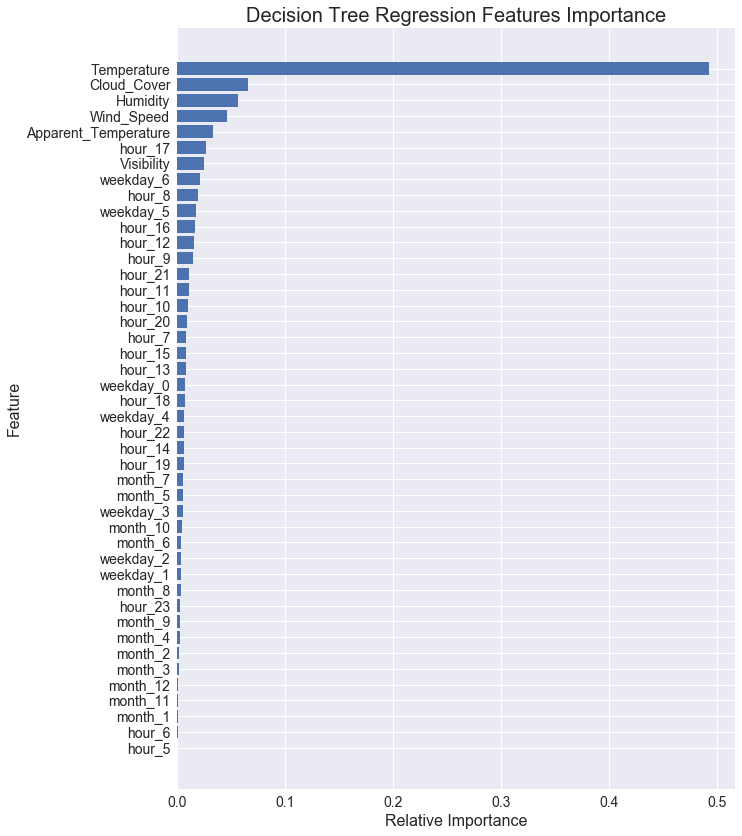

In [61]:
plot_feature_importances(dtr, 'Decision Tree Regression')

In [62]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 0.943
Testing Set Score: 0.679


,Random Forest Regression
R Squared,0.824289
RMSE,45.789939


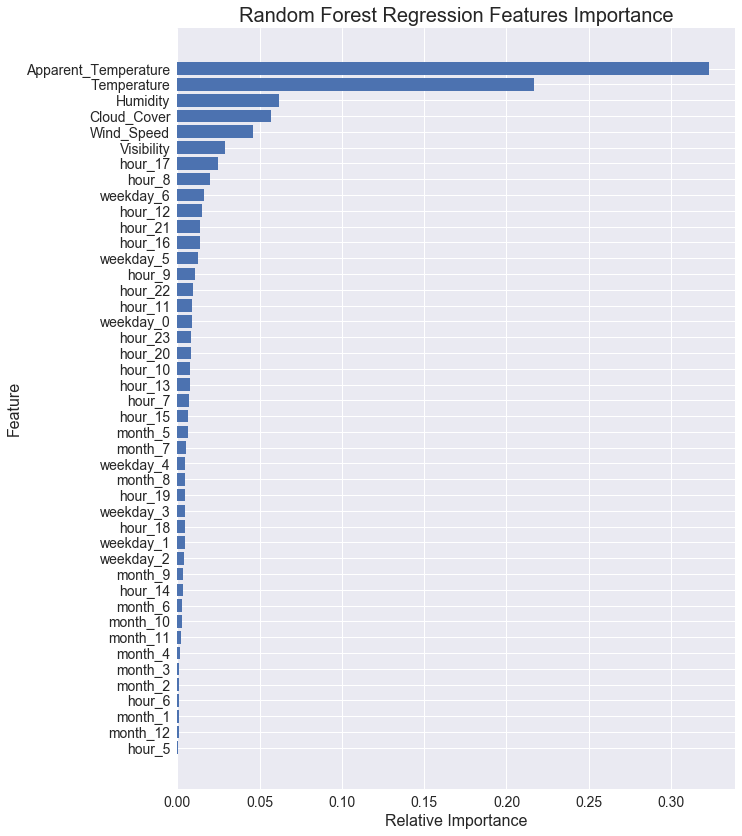

In [63]:
plot_feature_importances(rfr, 'Random Forest Regression')

#### Extra Trees Regression

In [64]:
# Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.699


,Extra Trees Regression
R Squared,0.835802
RMSE,43.059707


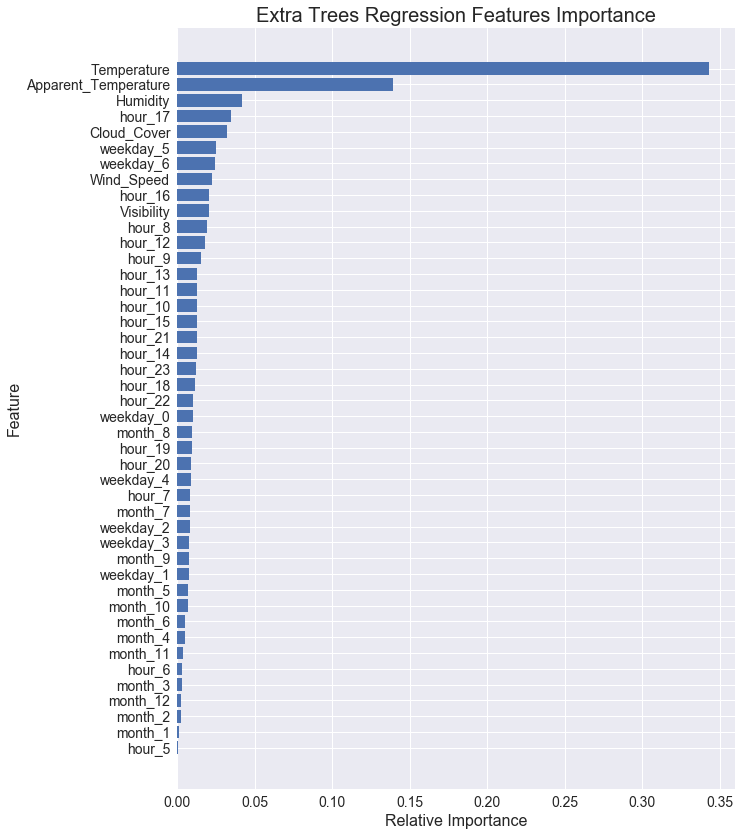

In [65]:
plot_feature_importances(etr, 'Extra Trees Regression')

#### Nearest Neighbors Regression

In [66]:
# Nearest Neighbors Regressor
knr = KNeighborsRegressor(n_neighbors=10)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 0.597
Testing Set Score: 0.496


,Nearest Neighbors Regression
R Squared,0.704000
RMSE,72.051003


## Regression Summary - Categorical Feature Set

In [67]:
# Regression Summary
print("Regression Summary - Categorical Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics,
                                dtr_metrics, rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary - Categorical Feature Set


,Linear Regression,Lasso Regression,Ridge Regression,Bayesion Ridge Regression,Decision Tree Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression
R Squared,0.822253,0.821127,0.821127,0.822232,0.650078,0.824289,0.835802,0.704000
RMSE,46.268837,46.533272,46.533272,46.273848,82.481079,45.789939,43.059707,72.051003


## 3. Modeling - Selected Features

In [68]:
data = dT.copy(deep=True)

In [69]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

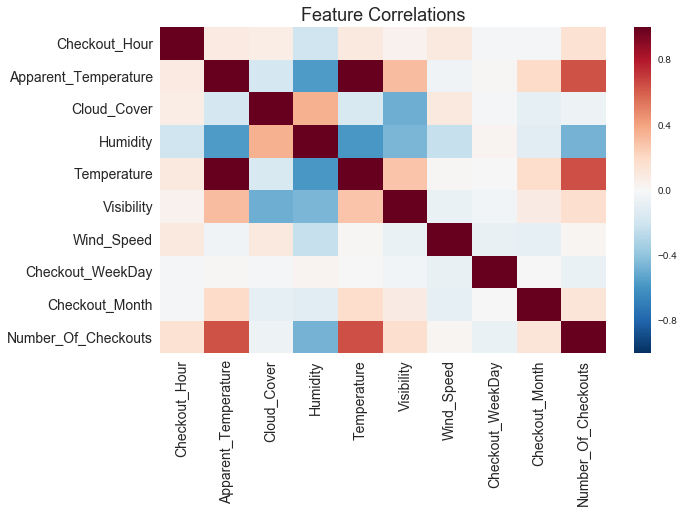

In [70]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
            'Number_Of_Checkouts']
plt.figure(figsize=(10,6))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [71]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]

In [72]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [73]:
array = data.values
X = array[:,0:9]
X[0]

array([ 1.  ,  4.  ,  0.  ,  7.52,  0.65,  0.01,  3.5 ,  0.83,  7.75])

In [74]:
y = array[:,9]
y[0]

1.0

In [75]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,6))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

### Linear Regression

In [76]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.coef_: [  0.04931324  -0.44113722   0.10545982   0.64226729  -0.24672626
   6.51506292  -0.260583   -12.48543803  -0.45869372]
lr.intercept_: 3.1266517692890226

Training Set Score: 0.452
Testing Set Score: 0.470


,Linear Regression
R Squared,0.685919
RMSE,74.533468


### Lasso Regression

In [77]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.1)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

Training Set Score: 0.444
Testing Set Score: 0.463


,Lasso Regression
R Squared,0.680605
RMSE,75.555613


### Ridge Regression

In [78]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.1)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

Training Set Score: 0.444
Testing Set Score: 0.463


,Ridge Regression
R Squared,0.680605
RMSE,75.555613


### Bayesian Ridge Regression

In [79]:
# Bayesian Ridge Regression
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

Training Set Score: 0.451
Testing Set Score: 0.471


,Bayesion Ridge Regression
R Squared,0.685989
RMSE,74.519813


### Decision Tree Regression

In [80]:
# Decision Tree Regression
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.481


,Decision Tree Regression
R Squared,0.693454
RMSE,73.070383


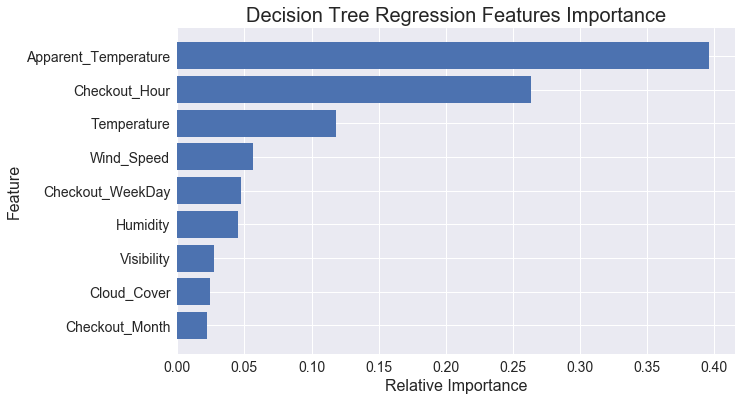

In [81]:
plot_feature_importances(dtr, 'Decision Tree Regression')


### Random Forest Regression

In [82]:
# Random Forest Regression
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 0.947
Testing Set Score: 0.735


,Random Forest Regression
R Squared,0.857242
RMSE,37.319948


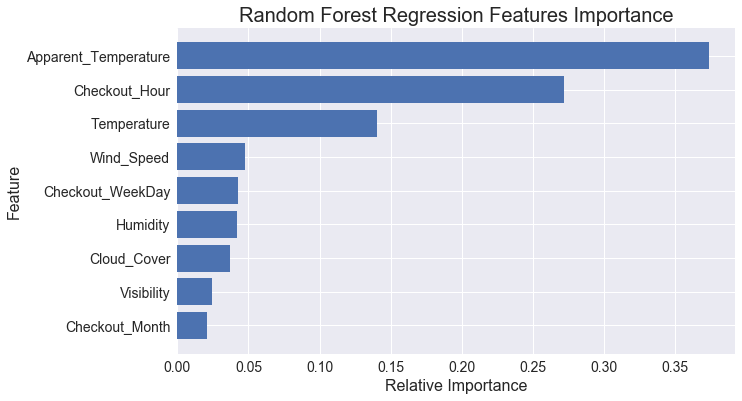

In [83]:
plot_feature_importances(rfr, 'Random Forest Regression')

### Extra Trees Regression

In [84]:
# Extra Trees Regression
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.739


,Extra Trees Regression
R Squared,0.859465
RMSE,36.782801


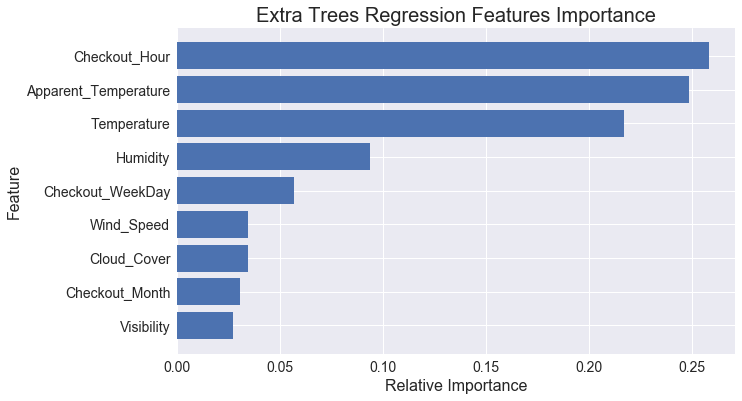

In [85]:
plot_feature_importances(etr, 'Extra Trees Regression')

### Nearest Neighbors Regression

In [86]:
# Nearest Neighbors Regression
knr = KNeighborsRegressor(n_neighbors=2)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 0.867
Testing Set Score: 0.616


,Nearest Neighbors Regression
R Squared,0.784742
RMSE,54.076287


## Regression Summary with Numerical Feature Set

In [87]:
# Regression Summary
print("Regression Summary With Numericical Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics, dtr_metrics,
                                rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary With Numericical Feature Set


,Linear Regression,Lasso Regression,Ridge Regression,Bayesion Ridge Regression,Decision Tree Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression
R Squared,0.685919,0.680605,0.680605,0.685989,0.693454,0.857242,0.859465,0.784742
RMSE,74.533468,75.555613,75.555613,74.519813,73.070383,37.319948,36.782801,54.076287


## Test Extra Trees Regressor on Unseen Samples

In [88]:
dUT = dUT[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
                 'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
pred_X = dUT[features]
act_y = dUT['Number_Of_Checkouts']
pred_array = dUT.values
pred_X_array = pred_array[:,0:9]
act_y_array = pred_array[:,9]
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X, y)
pred = etr.predict(pred_X_array)
print('pred =', pred)
print('act = ', act_y_array)

pred = [ 12.  48.   9.  33.  12.  13.   9.   6.   8.   5.]
act =  [ 12.  48.   9.  33.  12.  13.   9.   6.   8.   5.]


## 4. Summary

With reduced features, the Random Forest model attains the highest accuracy with the lowest RMSE. The linear models have almost four times higher RMSE values as compared to the Random Forest model. This suggests that the prediction can be improved even with reduced features.